In [3]:
# Date:         4/7/24 
# Last Update:  5/7/24 
# Course:       Advanced Communication Lab 
# Author:       Reshef Schachter, Boris Karasov 
# Lecturer:     Irena Libster 
# Project:      Advanced Communication Lab - Experiment 4 
# Description:  Hamming(7,4) encoding and error correction on a black and white image

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

######################################
############# Question 1 #############
######################################

# Open the image file
image_in = Image.open('C:/Users/sixsi/Code-Projects/PythonProjects/advanced_comm_lab/low_res_star.jpg')

image_in = image_in.convert('L')                    # Convert the image to grayscale
array_in = np.array(image_in).flatten()             # Convert the image to a 1D array
array_in = np.unpackbits(array_in.astype(np.uint8)) # Convert the array to 8 bit binary values

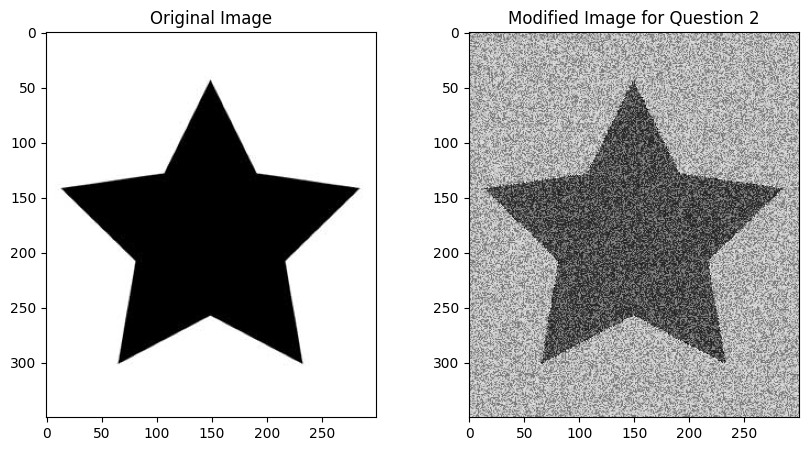

In [5]:
######################################
############# Question 2 #############
######################################

def add_noise(arr, blockSize, numErr): # Recieve an array, block size and number of errors to add
    newarr = arr.copy()
    for i in range(0, len(newarr), blockSize):
        errIndex = random.sample(range(0, blockSize - 1), numErr)
        for j in range(numErr):
            newarr[i + errIndex[j]] ^= 1
    return newarr
    

# Add noise to the array, 1 error per 4 bits
array = add_noise(array_in, 4, 1)

# Convert the array back into an image
array_q2 = np.packbits(array)
array_q2 = array_q2.reshape(image_in.size[::-1])
image_q2 = Image.fromarray(array_q2)


# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(image_in, cmap='gray')
plt.title('Original Image')
# Plot the modified image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(image_q2, cmap='gray')
plt.title('Modified Image for Question 2')
plt.show()

Errors added: 210000
Errors after decoding: 0


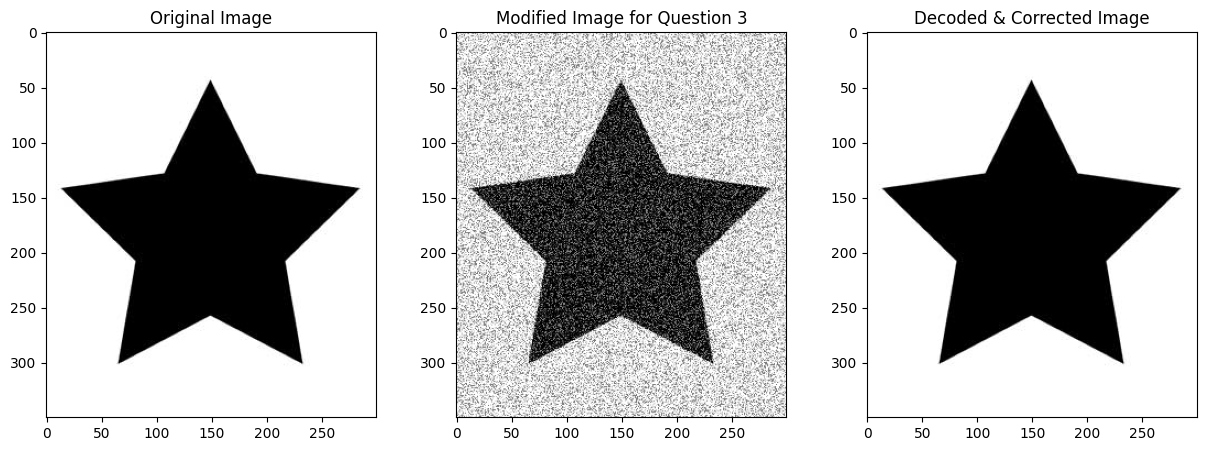

In [6]:
######################################
############# Question 3 #############
######################################

# Add Hamming(7,4) encoding in the form of: m1,p1,m2,p2,m3,p3,m4
# p1 = m1 xor m2 xor m4
# p2 = m1 xor m3 xor m4
# p3 = m2 xor m3 xor m4

def encode(arr): # Recieve 4 data bits and return 7 bits encoded
    m1 = arr[0]
    m2 = arr[1]
    m3 = arr[2]
    m4 = arr[3]
    p1 = m1 ^ m2 ^ m4
    p2 = m1 ^ m3 ^ m4
    p3 = m2 ^ m3 ^ m4
    return np.array([m1, p1, m2, p2, m3, p3, m4])

encoded_size = array_in.size * 7 // 4
array_hamming = np.zeros(encoded_size, dtype=np.uint8)

for i in range(0, array_in.size, 4):
    j = i * 7 // 4
    array_hamming[j:j + 7] = encode(array_in[i:i + 4])
    
# Add noise to the array, 1 error per 7 bits
array_hamming_noise = add_noise(array_hamming, 7, 1)

def decode_without_FEC(arr): # Recieve 7 bits and return 4 data bits
    return np.array([arr[0], arr[2], arr[4], arr[6]])

# Convert the array back into an image
array_q3_noisy = np.zeros(array_in.size, dtype=np.uint8)
for i in range(0, array_hamming_noise.size, 7):
    k = i * 4 // 7
    array_q3_noisy[k:k + 4] = decode_without_FEC(array_hamming_noise[i:i + 7])


# Print how many errors were added in total
flipped_bits = np.sum(array_hamming != array_hamming_noise)
print(f'Errors added: {flipped_bits}')

# Define the H matrix
H = np.array([[1,1,0],
              [1,0,0],
              [1,0,1],
              [0,1,0],
              [0,1,1],
              [0,0,1],
              [1,1,1]])

def decode(arr):
    syndrome = np.zeros(H.shape[1])
    for i in range(0, H.shape[1]):
        syndrome[i] = np.dot(H.T[i], arr) % 2
    if np.all(syndrome == 0):
        return np.array([arr[0], arr[2], arr[4], arr[6]])
    
    for i in range(0, H.shape[0]):
        if np.all(H[i,:] == syndrome.T):
            arr[i] ^= 1
            break
    return np.array([arr[0], arr[2], arr[4], arr[6]])


# Decode the Hamming(7,4) encoding in reversed order and correct the error, assign the corrected value to the decoded array
decoded_array = np.zeros(array.size, dtype=np.uint8)
for i in range(array_hamming_noise.size - 7, -1, -7):
    k = i * 4 // 7
    decoded_array[k:k + 4] = decode(array_hamming_noise[i:i + 7])

# Convert the both arrays back into an image
array_q3_with_noise = np.packbits(array_q3_noisy)
array_q3_with_noise = array_q3_with_noise.reshape(image_in.size[::-1])
image_q3_with_noise = Image.fromarray(array_q3_with_noise)
array_q3 = np.packbits(decoded_array)
array_q3 = array_q3.reshape(image_in.size[::-1])
image_q3 = Image.fromarray(array_q3)

flipped_bits = np.sum(array_in != decoded_array)
print(f'Errors after decoding: {flipped_bits}')

# Plot the original image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.imshow(image_in, cmap='gray')
plt.title('Original Image')
# Plot the noisy image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.imshow(image_q3_with_noise, cmap='gray')
plt.title('Modified Image for Question 3')
# Plot the decoded image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 2nd subplot
plt.imshow(image_q3, cmap='gray')
plt.title('Decoded & Corrected Image')
plt.show()

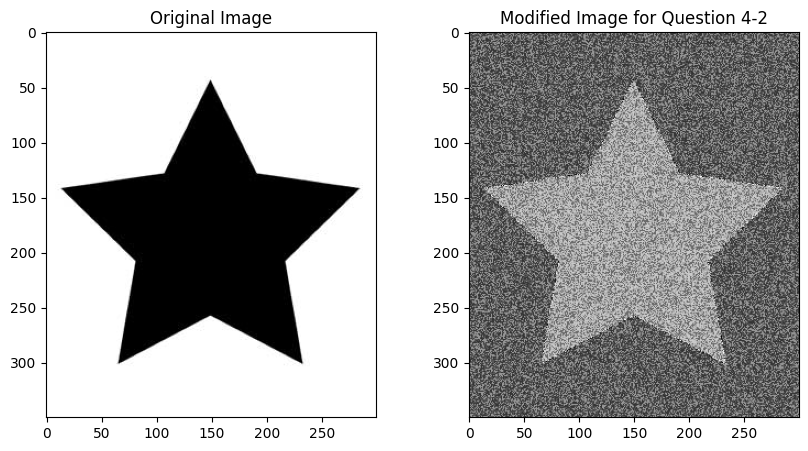

In [7]:
######################################
############ Question 4-2 ############
######################################

# Question 2 but with 2 errors per 4 bits

# Add noise to the array, 2 error per 4 bits
array = add_noise(array_in, 4, 2)

# Convert the array back into an image
array_q2 = np.packbits(array)
array_q2 = array_q2.reshape(image_in.size[::-1])
image_q2 = Image.fromarray(array_q2)


# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(image_in, cmap='gray')
plt.title('Original Image')
# Plot the modified image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(image_q2, cmap='gray')
plt.title('Modified Image for Question 4-2')
plt.show()

Errors added: 420000
Errors after decoding: 335896


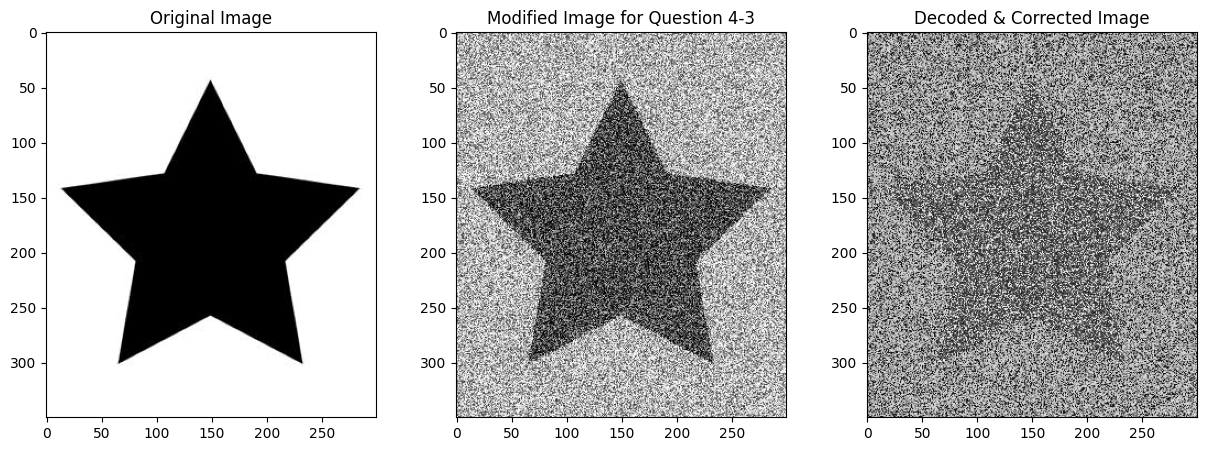

In [8]:
######################################
############ Question 4-3 ############
######################################

# Question 3 but with 2 errors per 7 bits
    
# Add noise to the array, 1 error per 7 bits
array_hamming_noise = add_noise(array_hamming, 7, 2)

# Convert the array back into an image
for i in range(0, array_hamming_noise.size, 7):
    k = i * 4 // 7
    array_q3_noisy[k:k + 4] = decode_without_FEC(array_hamming_noise[i:i + 7])

# Print how many errors were added in total
flipped_bits = np.sum(array_hamming != array_hamming_noise)
print(f'Errors added: {flipped_bits}')

# Decode the Hamming(7,4) encoding in reversed order and correct the error, assign the corrected value to the decoded array
for i in range(array_hamming_noise.size - 7, -1, -7):
    k = i * 4 // 7
    decoded_array[k:k + 4] = decode(array_hamming_noise[i:i + 7])

# Convert the both arrays back into an image
array_q3_with_noise = np.packbits(array_q3_noisy)
array_q3_with_noise = array_q3_with_noise.reshape(image_in.size[::-1])
image_q3_with_noise = Image.fromarray(array_q3_with_noise)
array_q3 = np.packbits(decoded_array)
array_q3 = array_q3.reshape(image_in.size[::-1])
image_q3 = Image.fromarray(array_q3)

flipped_bits = np.sum(array_in != decoded_array)
print(f'Errors after decoding: {flipped_bits}')

# Plot the original image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.imshow(image_in, cmap='gray')
plt.title('Original Image')
# Plot the noisy image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.imshow(image_q3_with_noise, cmap='gray')
plt.title('Modified Image for Question 4-3')
# Plot the decoded image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 2nd subplot
plt.imshow(image_q3, cmap='gray')
plt.title('Decoded & Corrected Image')
plt.show()

In [10]:
import numpy as np

def decode(arr):
    syndrome = np.zeros(H.shape[1])
    for i in range(0, H.shape[1]):
        syndrome[i] = np.dot(H.T[i], arr) % 2
    if np.all(syndrome == 0):
        return np.array([arr[0], arr[2], arr[4], arr[6]])
    
    for i in range(0, H.shape[0]):
        if np.all(H[i,:] == syndrome.T):
            arr[i] ^= 1
            break
    return np.array([arr[0], arr[2], arr[4], arr[6]])

print(decode([0,1,1,1,1,1,0]))

KeyboardInterrupt: 